In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [4]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [5]:
#tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
#tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
#tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
#tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

In [6]:
#tracking_df['gpid'] = tracking_df.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [7]:
runners = tracking_df.loc[(tracking_df['position'].isin(['QB', 'WR', 'RB', 'TE']))].copy()
del tracking_df

In [8]:
runners['pos'] = runners['pos'].apply(string_to_vector)
runners['o_vec'] = runners['o_vec'].apply(string_to_vector)
runners['dir_vec'] = runners['dir_vec'].apply(string_to_vector)
runners['r_vec'] = runners['r_vec'].apply(string_to_vector)
runners['gpid'] = runners.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [9]:
qb_positions = runners.loc[(runners['frameId'] == 1) & (runners['position'] == 'QB')][['gpid', 'pos']].copy()

In [10]:
runners = runners.loc[(~runners['route'].isna())]

In [11]:
# Convert nan forced floats to ints and NA
runners['nflId'] = runners['nflId'].astype('Int64')
runners['jerseyNumber'] = runners['jerseyNumber'].astype('Int64')

In [12]:
gpids = runners['gpid'].unique().tolist()

In [13]:
routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
index = 0
end_events = ['pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
                       'pass_outcome_incomplete', 'first_contact', 'tackle', 'man_in_motion', 'play_action', 'handoff',
                       'pass_tipped', 'pass_outcome_interception', 'pass_shovel', 'line_set', 'pass_outcome_touchdown',
                       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered', 'touchdown', 'shift',
                       'touchback', 'penalty_flag', 'penalty_accepted', 'field_goal_blocked']

# Generate vectors of positions
for gpid in gpids[:1000]:
    df = runners.loc[runners['gpid'] == gpid]
    players = df['nflId'].unique().tolist()
    centre_pos = qb_positions.loc[(qb_positions['gpid'] == gpid)]['pos'].values[0][1]
    for player in players:
        player_df = df.loc[(df['nflId'] == player)]
        if player > 0:
            start_frame = player_df.loc[player_df['event'] == 'ball_snap']['frameId'].min()
            end_frame = player_df.loc[player_df['event'].isin(end_events)]['frameId'].min()
            if end_frame > start_frame:
                positions = []
                start_pos = player_df.loc[(player_df['frameId'] == start_frame)]['pos'].values[0]
                flip_arr = True if start_pos[1] < centre_pos else False
                for frame in range(start_frame + 1, end_frame + 1):
                    # positions.append(player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist())
                    new_pos = player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist()
                    if flip_arr: new_pos[1] = new_pos[1] * -1
                    new_pos.append(player_df.loc[(player_df['frameId'] == frame)]['s'].values[0])
                    positions.append(new_pos)
                positions = np.array(positions)
                try:
                    routes_df.loc[index] = {
                        'gpid': str(gpid),
                        'nflId': int(player),
                        'route': str(player_df.loc[(player_df['frameId'] == 1)]['route'].values[0]),
                        'pos': positions - positions[0]
                    }
                    index += 1
                except IndexError:
                    print(f'Data error for gpid {gpid}, player {player} (Start {start_frame} | End {end_frame})')

del runners

In [14]:
# Convert position sequences to 2d array with np.histogram2d

In [15]:
# Convert 2d array to 1d array

(-40.0, 40.0)

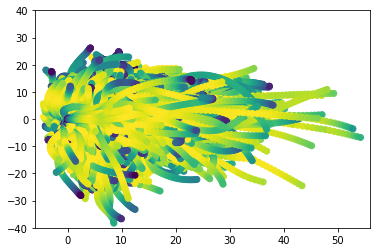

In [16]:
x = [0, 0]
y = [0, 0]

for idx, row in routes_df.iterrows():
    if row['pos'][:, 0].min() < x[0]: x[0] = row['pos'][:, 0].min()
    if row['pos'][:, 0].max() > x[1]: x[1] = row['pos'][:, 0].max()
    if row['pos'][:, 1].min() < y[0]: y[0] = row['pos'][:, 1].min()
    if row['pos'][:, 1].max() > y[1]: y[1] = row['pos'][:, 1].max()
    plt.scatter(row['pos'][:, 0], row['pos'][:, 1], c=row['pos'][:, 2])
x = [np.floor(x[0]), np.ceil(x[1])]
plt.xlim(x[0] - 1, x[1] + 1)
y[0] = -1 * np.ceil(max(abs(y[0]), abs(y[1])))
y[1] = abs(y[0])
plt.ylim(y[0] - 1, y[1] + 1)

In [17]:
x_dim = int(abs(x[0]) + abs(x[1]))
y_dim = int(abs(y[0]) + abs(y[1]))

In [18]:
grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)

In [19]:
grids = []
for idx, row in routes_df.iterrows():
    grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)
    for position in row['pos']:
        grid[int(position[0]), int(position[1])] = position[2]
    grids.append(grid.reshape(x_dim * y_dim))

In [20]:
routes_df['grid'] = grids
#routes_df.drop(['pos'], axis=1, inplace=True)

In [25]:
# flatten the images
n_samples = len(grids)

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.005, kernel='rbf')

# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route'], test_size=0.6, shuffle=False, random_state=1)

# Learn the digits on the train subset
clf.fit(x_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(x_test)

In [26]:
print(
    f'Classification report for classifier {clf}:\n'
    f'{metrics.classification_report(y_test, predicted)}\n'
)

Classification report for classifier SVC(gamma=0.005):
              precision    recall  f1-score   support

       ANGLE       0.67      0.12      0.20        84
      CORNER       0.00      0.00      0.00       102
       CROSS       0.63      0.29      0.40       204
        FLAT       0.61      0.75      0.67       295
          GO       0.36      0.73      0.48       478
       HITCH       0.36      0.65      0.47       322
          IN       0.40      0.13      0.20       174
         OUT       0.87      0.24      0.37       304
        POST       0.52      0.08      0.15       165
      SCREEN       0.31      0.43      0.36        88
       SLANT       0.55      0.23      0.33       147
       WHEEL       0.00      0.00      0.00        13

    accuracy                           0.43      2376
   macro avg       0.44      0.30      0.30      2376
weighted avg       0.50      0.43      0.39      2376




/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Confusion Matrix:
[[ 10   0   2  39   8  18   0   0   0   5   2   0]
 [  0   0   0   1  86  13   0   0   0   2   0   0]
 [  1   0  60  13  74  36   1   0   0  17   2   0]
 [  0   0   6 220  37   6   0   0   0  26   0   0]
 [  0   0   0  10 349  96   2   5   4  12   0   0]
 [  2   0   3  14  68 208   2   6   2   8   9   0]
 [  0   0   6   0  77  49  23   0   7   2  10   0]
 [  1   0   3  22 132  56   6  72   0   8   4   0]
 [  0   0   1   1 111  26  11   0  14   1   0   0]
 [  0   0   0  34   2  13   0   0   0  38   1   0]
 [  1   0  13   1  31  51  12   0   0   4  34   0]
 [  0   0   1   3   8   0   0   0   0   1   0   0]]


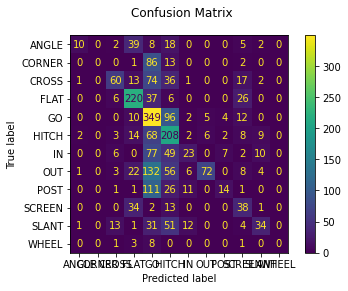

In [27]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

In [28]:
routes_df['route'].value_counts().sum()

3959

<BarContainer object of 12 artists>

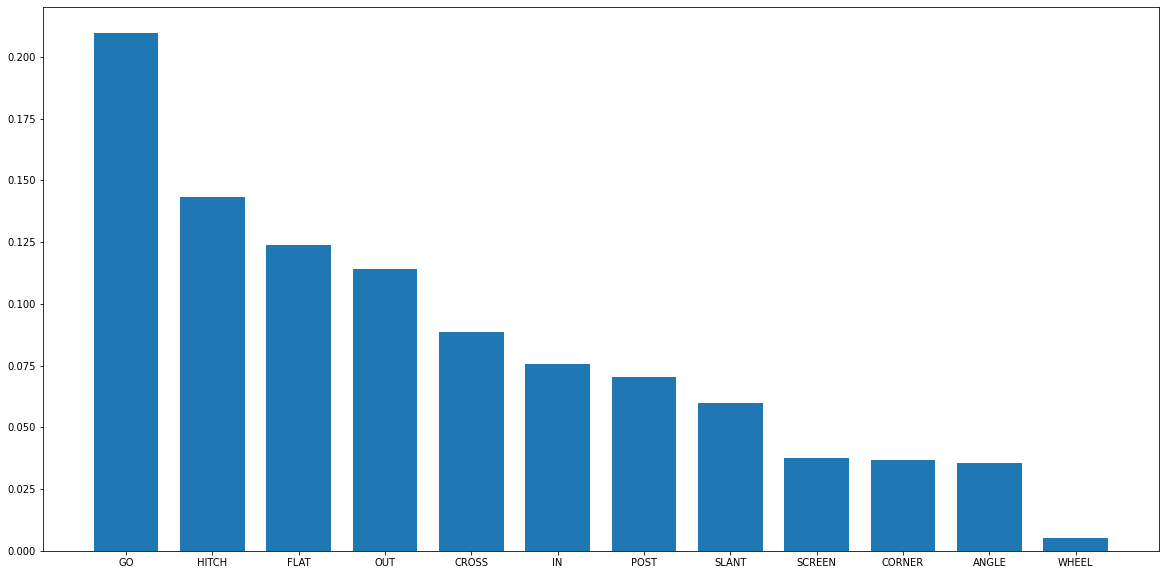

In [29]:
plt.figure(figsize=(20,10))
plt.bar(routes_df['route'].value_counts().index, routes_df['route'].value_counts().values / routes_df['route'].value_counts().sum(), width=0.75)

In [30]:
routes_df['route'].count()

3959

In [31]:
routes_df.loc[routes_df['route'] == 'WHEEL']['route'].count()

21

In [32]:
7142/39645

0.1801488207844621

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)

In [35]:
clf2 = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
clf2.fit(x_train2, y_train)

/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(max_iter=1000, random_state=1, solver='lbfgs')

In [36]:
predicted2 = clf2.predict(x_test2)

In [37]:
print(
    f'Classification report for classifier {clf2}:\n'
    f'{metrics.classification_report(y_test, predicted2)}\n'
)

Classification report for classifier MLPClassifier(max_iter=1000, random_state=1, solver='lbfgs'):
              precision    recall  f1-score   support

       ANGLE       0.30      0.21      0.25        84
      CORNER       0.22      0.14      0.17       102
       CROSS       0.46      0.46      0.46       204
        FLAT       0.60      0.70      0.65       295
          GO       0.51      0.57      0.54       478
       HITCH       0.37      0.46      0.41       322
          IN       0.28      0.25      0.26       174
         OUT       0.54      0.43      0.48       304
        POST       0.38      0.33      0.36       165
      SCREEN       0.41      0.36      0.39        88
       SLANT       0.29      0.30      0.29       147
       WHEEL       1.00      0.15      0.27        13

    accuracy                           0.45      2376
   macro avg       0.45      0.36      0.38      2376
weighted avg       0.44      0.45      0.44      2376




Confusion Matrix:
[[ 18   0   6  25   5  16   2   8   1   1   2   0]
 [  3  14   5   0  45   9   4  13   6   1   2   0]
 [  1   5  93  20   7  25  10   5   6   2  30   0]
 [  6   0  22 206   7   5   3  12   1  29   4   0]
 [  6  20   5  17 273  77  10  33  24   4   9   0]
 [ 11   8  13  11  45 148  17  24  15   3  27   0]
 [  1   3  22   2  27  32  43   3  22   0  19   0]
 [  8   9   8  20  56  38  15 131   6   3  10   0]
 [  0   3   9   2  48   8  32   5  55   1   2   0]
 [  6   0   3  28   3   8   1   2   1  32   4   0]
 [  1   3  16   5  16  30  19   5   7   1  44   0]
 [  0   0   1   7   1   0   0   1   0   1   0   2]]


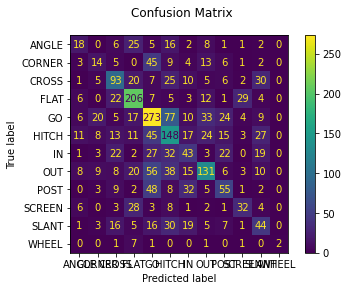

In [38]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted2)
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.show()

In [39]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [40]:
model.fit(x_train2, y_train)

RandomForestClassifier()

In [41]:
y_pred = model.predict(x_test2)

In [42]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [43]:
accuracy_score(y_pred, y_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       ANGLE       0.30      0.38      0.33        66
      CORNER       0.03      0.23      0.05        13
       CROSS       0.62      0.59      0.60       216
        FLAT       0.79      0.59      0.68       393
          GO       0.73      0.47      0.57       732
       HITCH       0.52      0.44      0.48       379
          IN       0.29      0.47      0.36       106
         OUT       0.37      0.76      0.50       148
        POST       0.25      0.40      0.31       103
      SCREEN       0.26      0.48      0.34        48
       SLANT       0.50      0.43      0.47       171
       WHEEL       0.08      1.00      0.14         1

    accuracy                           0.51      2376
   macro avg       0.39      0.52      0.40      2376
weighted avg       0.59      0.51      0.53      2376



In [44]:
confusion_matrix(y_pred, y_test)

array([[ 25,   1,   2,   4,   5,  10,   0,   7,   1,   7,   4,   0],
       [  0,   3,   0,   0,   4,   0,   2,   1,   2,   0,   1,   0],
       [  6,   3, 127,  21,   6,   9,   8,   6,   7,   4,  19,   0],
       [ 29,   1,  20, 233,  20,  11,   2,  20,   2,  39,   4,  12],
       [  5,  68,   4,  15, 347,  74,  38, 101,  63,   2,  15,   0],
       [ 16,  11,  17,   2,  47, 168,  40,  37,  15,  10,  16,   0],
       [  0,   1,   2,   1,   2,   9,  50,   5,  29,   0,   7,   0],
       [  1,   4,   0,   4,  16,   5,   2, 112,   2,   1,   1,   0],
       [  0,   7,   3,   0,  18,  10,  16,   3,  41,   0,   5,   0],
       [  1,   0,   1,  13,   5,   2,   0,   1,   1,  23,   1,   0],
       [  1,   3,  28,   2,   8,  24,  16,  11,   2,   2,  74,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1]])

In [21]:
# Test NN using pytorch
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [46]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [48]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [49]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([7])


In [77]:
# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(x_dim*y_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 11),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [78]:
# Train the model
model2 = NeuralNetwork().to(device)
print(model)
logits2 = model2(torch.as_tensor(x_train).float())

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [79]:
# Evaluate the model
pred_probab = nn.Softmax(dim=1)(logits2)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0, 2, 0,  ..., 0, 0, 0])


In [80]:
max(logits2.max(1).indices)

tensor(10)

In [27]:
classes = {}
index = 0
for route in routes_df['route'].unique().tolist():
    classes[index] = route
    index += 1
classes

{0: 'HITCH',
 1: 'OUT',
 2: 'FLAT',
 3: 'CROSS',
 4: 'GO',
 5: 'SLANT',
 6: 'SCREEN',
 7: 'CORNER',
 8: 'IN',
 9: 'ANGLE',
 10: 'POST',
 11: 'WHEEL'}

In [28]:
route_idx = {}
for idx, value in classes.items():
    route_idx[value] = idx
route_idx

{'HITCH': 0,
 'OUT': 1,
 'FLAT': 2,
 'CROSS': 3,
 'GO': 4,
 'SLANT': 5,
 'SCREEN': 6,
 'CORNER': 7,
 'IN': 8,
 'ANGLE': 9,
 'POST': 10,
 'WHEEL': 11}

In [30]:
routes_df['route_int'] = routes_df['route'].apply(lambda x: route_idx[x])
routes_df.head()

,gpid,nflId,route,pos,grid,route_int
0,2018090600-75,2495454,HITCH,"[[0.0, 0.0, 0.0], [0.030000000000001137, 0.0, ...","[3.48, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,2018090600-75,2533040,HITCH,"[[0.0, 0.0, 0.0], [0.010000000000001563, 0.0, ...","[2.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,2018090600-75,2555415,OUT,"[[0.0, 0.0, 0.0], [0.010000000000001563, 0.009...","[2.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,2018090600-146,2543583,FLAT,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.04], [0.0099999...","[2.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
4,2018090600-146,2552418,CROSS,"[[0.0, 0.0, 0.0], [0.01999999999999602, 0.0199...","[2.86, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3


In [53]:
import torch
from torch import nn

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [65]:
class MultiClassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=0):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

mc_model = MultiClassModel(input_features=x_dim*y_dim, output_features=len(classes), hidden_units=1024).to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(mc_model.parameters(), lr=0.2)

In [66]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route_int'], test_size=0.2, shuffle=False, random_state=1)

torch.manual_seed(42)
epochs = 1000

x_train, y_train = torch.as_tensor(x_train).float().to(device), torch.as_tensor(y_train.to_numpy()).to(device)
x_test, y_test = torch.as_tensor(x_test).float().to(device), torch.as_tensor(y_test.to_numpy()).to(device)

for epoch in range(epochs):
    ### Training
    mc_model.train()

    # 1. Forward Pass
    y_logits = mc_model(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and energy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimiser zero grad
    optimiser.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    ### Testing
    mc_model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = mc_model(x_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.48365, Acc: 6.60% | Test Loss: 2.46713, Test Acc: 20.96%
Epoch: 10 | Loss: 2.28643, Acc: 20.87% | Test Loss: 2.26488, Test Acc: 21.34%
Epoch: 20 | Loss: 2.11790, Acc: 20.87% | Test Loss: 2.10389, Test Acc: 21.34%
Epoch: 30 | Loss: 1.97276, Acc: 33.38% | Test Loss: 1.96567, Test Acc: 32.20%
Epoch: 40 | Loss: 1.79480, Acc: 39.72% | Test Loss: 1.81022, Test Acc: 37.50%
Epoch: 50 | Loss: 1.70418, Acc: 41.24% | Test Loss: 1.73273, Test Acc: 38.38%
Epoch: 60 | Loss: 1.80346, Acc: 34.86% | Test Loss: 1.72599, Test Acc: 36.99%
Epoch: 70 | Loss: 1.63154, Acc: 39.75% | Test Loss: 1.64051, Test Acc: 38.13%
Epoch: 80 | Loss: 1.54282, Acc: 44.65% | Test Loss: 1.59680, Test Acc: 39.65%
Epoch: 90 | Loss: 1.48659, Acc: 47.33% | Test Loss: 1.57071, Test Acc: 41.79%
Epoch: 100 | Loss: 1.46185, Acc: 48.12% | Test Loss: 1.60936, Test Acc: 41.67%
Epoch: 110 | Loss: 1.40079, Acc: 48.59% | Test Loss: 1.56155, Test Acc: 41.29%
Epoch: 120 | Loss: 1.35395, Acc: 50.55% | Test Loss: 1.54887, Te

In [39]:
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route_int'], test_size=0.2, shuffle=False, random_state=1)

In [40]:
y_test

3167    2
3168    0
3169    4
3170    7
3171    4
       ..
3954    4
3955    7
3956    8
3957    1
3958    5
Name: route_int, Length: 792, dtype: int64

In [41]:
y_train

0       0
1       0
2       1
3       2
4       3
       ..
3162    8
3163    0
3164    0
3165    2
3166    0
Name: route_int, Length: 3167, dtype: int64